### Topic modeling with NMF and LDA

1. Load dataframe of neighborhoods and extract neighborhood descriptions (lemmas)
2. Create vector, complete topic modeling, and assign topic distributions to each neighborhood:
    * NMF
    * LDA
4. Visualize topics with tSNE

Resources:
* [Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation](http://scikit-learn.org/stable/auto_examples/applications/topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-topics-extraction-with-nmf-lda-py)
* [Practical Topic Finding for Short-Sentence Texts](http://nbviewer.jupyter.org/github/dolaameng/tutorials/blob/master/topic-finding-for-short-texts/topics_for_short_texts.ipynb)
* [Topic Modeling with Scikit Learn](https://medium.com/@aneesha/topic-modeling-with-scikit-learn-e80d33668730#.gabw32h5e)
* [Improving the Interpretation of Topic Models](https://medium.com/towards-data-science/improving-the-interpretation-of-topic-models-87fd2ee3847d#.8j9ngyi91)
* [Care and Feeding of Topic Models: Problems, Diagnostics, and Improvements](https://mimno.infosci.cornell.edu/papers/2014_book_chapter_care_and_feeding.pdf)
* [Getting started with Latent Dirichlet Allocation in Python](http://chrisstrelioff.ws/sandbox/2014/11/13/getting_started_with_latent_dirichlet_allocation_in_python.html)
* [An illustrated introduction to the t-SNE algorithm](https://github.com/oreillymedia/t-SNE-tutorial)

In [1]:
import pickle
import operator

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.decomposition import NMF, LatentDirichletAllocation

import json

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import _joint_probabilities, _kl_divergence
from sklearn.utils.extmath import _ravel

import matplotlib.patheffects as PathEffects

In [2]:
#function to display top words within each topic
def display_topics(model, W, features, n):
    best_hosts = []
    for index, topic in enumerate(model.components_):
        print 'Topic %d:' % index
        print 'TOP %d WORDS:' % n
        for i in topic.argsort()[:-n - 1:-1]:
            print features[i]
        print 'REPRESENTATIVE HOST:'
        ind = np.argsort(W[:,index])[::-1][0]
        best_hosts.append(ind)
        print df_neighborhoods.iloc[ind][['neighborhood', 'city', 'state']]
        print
    return best_hosts

In [3]:
#parameters for topic models
num_topics = 16
num_top_words = 8

#### Load AirBnB neighborhoods dataframe and extract preprocessed neighborhood descriptions

In [4]:
with open('../data/interim/04_neighborhoods_lemmas.pkl', 'rb') as picklefile:
    df_neighborhoods = pickle.load(picklefile)

In [5]:
lemmas = df_neighborhoods['lemmas']

In [6]:
neighborhoods = df_neighborhoods['neighborhood'].tolist()
cities = df_neighborhoods['city'].tolist()
states = df_neighborhoods['state'].tolist()
loc = zip(neighborhoods, cities, states)

In [7]:
df_neighborhoods.reset_index(drop=True, inplace=True)

### NMF (sklearn)

#### Create TFIDF vector using neighborhood descriptions

In [8]:
nmf_vectorizer = TfidfVectorizer(ngram_range=(1,2),
                                 max_df=0.75,
                                 min_df=20,
                                 max_features = 1000)

tfidf = nmf_vectorizer.fit_transform(lemmas)
nmf_features = nmf_vectorizer.get_feature_names()
len(nmf_features)

1000

In [9]:
#10 words with highest tfidf
top = nmf_vectorizer.idf_.argsort()[:10].tolist()
[(nmf_features[i], nmf_vectorizer.idf_[i]) for i in top]

[(u'include', 1.2936522394382846),
 (u'friendly', 1.2936522394382846),
 (u'love', 1.2951503670593068),
 (u'bus', 1.2981533723190763),
 (u'market', 1.2981533723190763),
 (u'offer', 1.3194307707663613),
 (u'ride', 1.3194307707663613),
 (u'enjoy', 1.3333521092849692),
 (u'go', 1.360188763238529),
 (u'residential', 1.3617900446055029)]

In [10]:
#10 words with lowest tfidf
bottom = nmf_vectorizer.idf_.argsort()[::-1].tolist()[:20]
[(nmf_features[i], nmf_vectorizer.idf_[i]) for i in bottom]

[(u'frenchman', 4.7534179752515069),
 (u'museum botanical', 4.6624461970457807),
 (u'tokyo', 4.3967430313127753),
 (u'dodger', 4.3967430313127753),
 (u'km', 4.2715798883587688),
 (u'rockefeller', 4.2144214745188204),
 (u'botanic', 4.2144214745188204),
 (u'arboretum', 4.1870225003307056),
 (u'natural history', 4.1870225003307056),
 (u'childrens museum', 4.134378766845284),
 (u'esplanade', 4.134378766845284),
 (u'fifth', 4.0602707946915615),
 (u'caribbean', 3.9477928112648719),
 (u'fest', 3.8466966943935033),
 (u'sand', 3.8466966943935033),
 (u'westside', 3.8089563664106558),
 (u'sculpture', 3.8089563664106558),
 (u'flea market', 3.7906072277424596),
 (u'institute', 3.7548891451403801),
 (u'latino', 3.7374974024285113)]

#### Extract topics using NMF on TFIDF vector of host descriptions
* Number of components set to number of topics
* init set to Nonnegative Double Singular Value Decomposition (nndsvd), which is better for sparse matrices
* solver set to cd (recommended in documentation)

In [11]:
nmf = NMF(n_components=num_topics,
          init='nndsvd',
          solver = 'cd',
          random_state=16)
nmf_doc_topic = nmf.fit_transform(tfidf)
nmf_doc_topic.shape

(895, 16)

In [12]:
nmf_topic_word = nmf.components_
nmf_topic_word.shape

(16, 1000)

In [13]:
best_nmf_hosts = display_topics(nmf, nmf_doc_topic, nmf_features, num_top_words)

Topic 0:
TOP 8 WORDS:
music
coffee shop
restaurant bar
venue
bar restaurant
hip
taco
cafe
REPRESENTATIVE HOST:
neighborhood    Bellmont Hillsboro
city                     nashville
state                           TN
Name: 48, dtype: object

Topic 1:
TOP 8 WORDS:
subway
subway stop
stop
subway subway
apartment
time
monument
building
REPRESENTATIVE HOST:
neighborhood    Ralph Bunche
city                 oakland
state                     CA
Name: 646, dtype: object

Topic 2:
TOP 8 WORDS:
train
diverse
supermarket
pharmacy
bus
jfk
laundromat
chinese
REPRESENTATIVE HOST:
neighborhood     Ozone Park
city            newyorkcity
state                    NY
Name: 593, dtype: object

Topic 3:
TOP 8 WORDS:
museum
science
art museum
academy
art
hospital
aquarium
botanical
REPRESENTATIVE HOST:
neighborhood    Carnegie Hill
city              newyorkcity
state                      NY
Name: 105, dtype: object

Topic 4:
TOP 8 WORDS:
market
farmer
farmer market
sunday
cafe
saturday
bakery
market sunday


In [14]:
nmf_topics = ['1_taco', '2_subway', '3_car', '4_museum', '5_farmer', '6_campus', \
             '7_diverse', '8_art', '9_nightlife', '10_attractions', '11_golf', \
              '12_outdoors', '13_streetcars', '14_water', '15_breweries', '16_bikes']

#### A couple visualizations!

In [15]:
len(nmf_topic_word[0])

1000

In [16]:
#plot importance of each word for each topic (1 plot per topic)
def plot_word_prob(topics, topic_word):
    f, ax= plt.subplots(len(topics), 1, figsize=(8, 24), sharex=True)
    x_min = -50
    x_max = len(topic_word[0]) + 50
    y_min = 0
    
    for i, k in enumerate(topics):
        y_max = round(max(topic_word[i])*1.1, 1)
        ax[i].stem(topic_word[i], linefmt='b-', markerfmt='bo', basefmt='w-')
        ax[i].set_xlim(x_min, x_max)
        ax[i].set_ylim(y_min, y_max)
        ax[i].set_ylabel("Importance")
        ax[i].set_title("topic {}".format(k))

    plt.tight_layout()
    plt.show()

In [ ]:
plot_word_prob(nmf_topics, nmf_topic_word)

In [17]:
#plot importance of all topics for document most representative of each topic (1 plot per topic)
def plot_doc_prob(best_hosts, doc_topic):
    f, ax= plt.subplots(len(best_hosts), 1, figsize=(8, 24), sharex=True)
    x_min = -1
    x_max = len(best_hosts)
    y_min = 0
    y_max = max(1, round(max(doc_topic.flatten())*1.1, 1))
    
    for i, k in enumerate(best_hosts):
        ax[i].stem(doc_topic[k], linefmt='r-', markerfmt='ro', basefmt='w-')
        ax[i].set_xlim(x_min, x_max)
        ax[i].set_ylim(y_min, y_max)
        ax[i].set_ylabel("Importance")
        ax[i].set_title("Document {}".format(k))

    plt.tight_layout()
    plt.show()

In [ ]:
plot_doc_prob(best_nmf_hosts, nmf_doc_topic)

#### Assign clusters

In [20]:
df_topics = pd.DataFrame(nmf_doc_topic)

In [21]:
df_topics['topic_num'] = df_topics.idxmax(axis=1)

In [22]:
df_topics['topic'] = df_topics['topic_num'].map(pd.Series(nmf_topics))

In [23]:
df_topics['neighborhood'] = df_neighborhoods['neighborhood']
df_topics['city'] = df_neighborhoods['city']

In [36]:
pilsen_dist = np.array(df_topics[df_topics['neighborhood'] == 'Pilsen'][range(0,16)])[0]

In [37]:
pilsen_dist

array([ 0.06650783,  0.0134261 ,  0.03119725,  0.03917936,  0.02348643,
        0.01304718,  0.        ,  0.24286662,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00542338,  0.        ,  0.        ])

In [48]:
import seaborn as sns
sns.set_style('white')

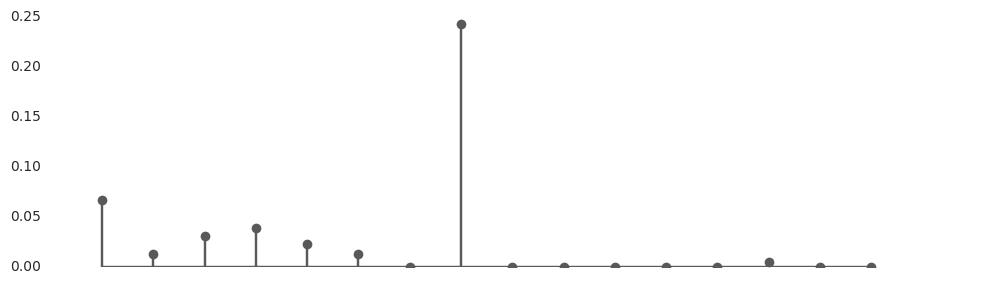

In [57]:
f, ax= plt.subplots(1, 1, figsize=(10, 3), sharex=True)
x_min = -1
x_max = 17
y_min = 0
y_max = 0.25

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_frame_on(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(True)

markerline, stemlines, baseline = ax.stem(pilsen_dist) #, linefmt='k-', markerfmt='ko', basefmt='k-')
plt.setp(markerline, 'color', '#595959')
plt.setp(stemlines, 'color', '#595959')
plt.setp(baseline, 'color', '#595959')

plt.tight_layout()
plt.show()

In [ ]:
with open('../data/interim/05_nmf_topics.pkl', 'wb') as picklefile:
    pickle.dump(df_topics, picklefile)

In [ ]:
#csv for d3 visualizations
df_nmf_topic_word = pd.DataFrame(nmf_topic_word).T

vocab = nmf_vectorizer.vocabulary_
sorted_nmf_words = sorted(vocab.items(), key=operator.itemgetter(1))
indices = [x[0].encode('utf-8') for x in sorted_nmf_words]

df_nmf_topic_word['word'] = indices

#all topic_word importances
df_nmf_topic_word.to_csv('../reports/viz/data/nmf_topic_word.csv', index=False)

In [ ]:
#separate csv with top 10 words in each topic
#function to display top words within each topic
def export_words(model, W, features, n):
    df_temp = pd.DataFrame()
    for index, topic in enumerate(model.components_):
        #print 'Topic %d:' % index
        for i in topic.argsort()[:-n - 1:-1]:
            word = features[i]
            importance = round(topic[i]*1000000)
            #print word, importance
            df_temp = df_temp.append(pd.Series([index, word, importance]), ignore_index=True)
        #print
    df_temp.columns = ['topic', 'word', 'importance']
    df_temp.to_csv('../reports/viz/data/nmf_top_10_words.csv', index=False)
    return df_temp

In [ ]:
df = export_words(nmf, nmf_doc_topic, nmf_features, 10)

In [ ]:
#csv for distribution of neighborhood clusters
cities = {'austin': 'Austin, TX',
          'boston': 'Boston, MA',
          'chicago': 'Chicago, IL',
          'denver': 'Denver, CO',
          'losangeles': 'Los Angeles, CA',
          'nashville': 'Nasville, TN', 
          'neworleans': 'New Orleans, LA',
          'newyorkcity': 'New York, NY', 
          'oakland' : 'Oakland, CA', 
          'portland': 'Portland, OR', 
          'sandiego': 'San Diego, CA', 
          'sanfrancisco': 'San Francisco, CA', 
          'seattle': 'Seattle, WA', 
          'washingtondc': 'Washington, DC'}

df_cities = pd.DataFrame.from_dict(cities, orient='index').reset_index()
df_cities.columns = ['index', 'city_proper']

df_lat_long = pd.read_csv('../reports/viz/data/city_totals.csv', usecols=['city_proper', 'lat', 'lng'])

df_cities = df_cities.merge(df_lat_long, on='city_proper')

In [ ]:
df_cities.head()

In [ ]:
df_city_topics = df_topics.groupby(['city', 'topic']).count()['topic_num'].unstack(fill_value=0).reset_index()

In [ ]:
df_cities.merge(df_city_topics, left_on='index', right_on='city').to_csv('../reports/viz/data/neighborhood_clusters.csv')

#### Pickle files for flask app

In [ ]:
df_loc = df_topics[['neighborhood', 'city', 'topic']]

In [ ]:
df_nmf_doc_topic = pd.DataFrame(nmf_doc_topic)

In [ ]:
kojak_demo = [df_loc, df_nmf_doc_topic, nmf_topics]
with open('../models/05_kojak_demo.pkl', 'wb') as picklefile:
    pickle.dump(kojak_demo, picklefile)

#### Visualizations for presenting

In [ ]:
import seaborn as sns
sns.set_style('white')

In [ ]:
viz_topics = {0: 1, 1: 4}

In [ ]:
def plot_for_viz(index, topic, topic_word, features):
    #print features[topic_word[index].argmax()[:3]]
    
    f, ax= plt.subplots(1, 1, figsize=(8, 2), sharex=True)
    x_min = -10
    x_max = len(topic_word[0])+10
    y_min = 0
    y_max = round(max(topic_word[index])*1.1, 1)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_frame_on(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    markerline, stemlines, baseline = ax.stem(topic_word[index]) #, linefmt='k-', markerfmt='ko', basefmt='k-')
    plt.setp(markerline, 'color', '#595959')
    plt.setp(stemlines, 'color', '#595959')
    plt.setp(baseline, 'color', '#595959')
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_for_viz(4, 'outdoorsy', nmf_topic_word, nmf_features)

In [ ]:
plot_for_viz(1, 'professional', nmf_topic_word, nmf_features)

#### Assign topic distribution to each listing

#### Pickle nmf topics dataframe

### LDA (sklearn)

#### Create term frequency vector using host descriptions (stopwords removed)

In [ ]:
lda_vectorizer = CountVectorizer(#strip_accents = 'unicode',
                                #stop_words = 'english',
                                #lowercase = True,
                                #token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_features = 1000,
                                ngram_range=(1,2),
                                max_df = 0.75, 
                                min_df = 20)
counts = lda_vectorizer.fit_transform(lemmas)
lda_features = lda_vectorizer.get_feature_names()
len(lda_features)

#### Extract topics using LDA on counts vector of host descriptions
* Number of components set to number of topics
* Learning method set to online for better performance

In [ ]:
lda = LatentDirichletAllocation(n_topics=num_topics,
                                learning_method='online',
                                random_state=16)
lda_doc_topic = lda.fit_transform(counts)

In [ ]:
lda_topic_word = lda.components_

In [ ]:
best_lda_hosts = display_topics(lda, lda_doc_topic, lda_features, num_top_words)

#### Visualizations

In [ ]:
lda_topics = range(num_topics)

In [ ]:
lda_topic_word_norm = lda_topic_word/np.sum(lda_topic_word, axis=1, keepdims=True)

In [ ]:
plot_word_prob(lda_topics, lda_topic_word)

In [ ]:
plot_doc_prob(best_lda_hosts, lda_doc_topic)

#### Visualizations for presenting

In [ ]:
plot_for_viz(9, 'outdoorsy', lda_topic_word, lda_features)

In [ ]:
plot_for_viz(10, 'professional', lda_topic_word, lda_features)

#### Assign topic distribution to each listing

In [ ]:
lda_topics = pd.DataFrame(lda_doc_topic, columns=lda_topics)

In [ ]:
lda_topics.head()

#### Pickle lda topics dataframe

In [ ]:
with open('../data/interim/lda_topics.pkl', 'wb') as picklefile:
    pickle.dump(lda_topics, picklefile)